In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_probability.substrates import numpy as tfp
from cmdstanpy import CmdStanModel, set_cmdstan_path
import arviz as az

In [42]:
X = pd.read_csv("../Datasets/covariates.csv")
Y = pd.read_csv("../Datasets/Dataset_120.csv")
Y.loc[:,'Count_120'] = pd.to_numeric(Y['Count_120']).astype('Int64')
X = pd.get_dummies(X ,columns = ['Type'] ,prefix = 'type', drop_first = True)
X.loc[X['Station'] == 10171, 'Quota'] = 10

In [43]:
rows_to_drop_Y = Y[Y['Count_120'].isna()].index

# Remove corresponding rows from dataset X
X = X.drop(index=rows_to_drop_Y)
Y = Y.drop(index=rows_to_drop_Y)

# If you want to reset the index after dropping rows
X = X.reset_index(drop=True)
Y = Y.reset_index(drop=True)

In [44]:
stations = X['Station']
years = X['Year'] - 2009
unique_values = sorted(set(stations))
mapping_dict = {value: index + 1 for index, value in enumerate(unique_values)}
transformed_stations = [mapping_dict[value] for value in stations]

In [45]:
base_model = """

data {
  int<lower=1> N; // Number of observations
  int<lower=1> P; // Covariate number
  int<lower=1> nyears;
  int<lower=1> nstations;


  array[N] int<lower=1> station;
  array[N] int<lower=1> year;
  // array[N] int<lower=4, upper=10> month;

  array[N] int<lower=0> y; // Count data
  matrix[N, P] X; // Predictor matrix
}

parameters {
  vector[P] beta; // Coefficients for predictors
  //vector[nstations] eta; // Random effects for comuni
  //vector[nyears] xi; // Random effects for years

  //real<lower=0> sigma0; // Standard deviation for beta
  //real<lower=0> sigma1; // Standard deviation for xi
  //real<lower=0> sigma2; // Standard deviation for eta
}

transformed parameters {
    vector[N] lambda;
    //vector[N] intercept;
    vector[N] fix_eff;

    //intercept = xi[year] + eta[station];
    fix_eff = X * beta;

    //lambda = exp(intercept + fix_eff);
    lambda = exp(fix_eff);
}

model {

  beta ~ normal(0, 2);
  //xi ~ normal(0, 2);
  //eta ~ normal(0, 2);
  y[1:N] ~ poisson(lambda[1:N]);


}
generated quantities{
 vector[N] log_lik;
 for(i in 1:N){
   log_lik [ i ] = poisson_lpmf (y [ i ] |lambda[i]) ;
}
}

"""

stan_file = "./base.stan"

with open(stan_file, "w") as f:
    print(base_model, file=f)

model_base = CmdStanModel(stan_file=stan_file)

03:14:02 - cmdstanpy - INFO - compiling stan file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.stan to exe file C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe
03:15:40 - cmdstanpy - INFO - compiled model executable: C:\Users\matte\Desktop\Bayesian_Stat\Bayesian_Project\main\Modello\base.exe


In [46]:
X = X.drop(['Year','Station','Month'], axis  = 1)

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)
X_std.loc[:,"type_rural"] = X.loc[:,"type_rural"]
X_std.loc[:,"type_urban"] = X.loc[:,"type_urban"]
X_std.loc[:,"type_rural"] = pd.to_numeric(X_std.loc[:,"type_rural"]).astype('Int64')
X_std.loc[:,"type_urban"] = pd.to_numeric(X_std.loc[:,"type_urban"]).astype('Int64')
X_std.head()

mean_temperature  mean_precipitation_sum  mean_precipitation_hours  \
0         -1.427024               -0.608034                 -0.028251   
1         -0.676275                2.540869                  2.016045   
2          0.428463               -0.188775                  0.329701   
3          1.453029               -1.003430                 -0.981119   
4          0.529757                1.317785                  0.374383   

   mean_windspeed_10m_max  mean_radiation_sum  count_highwind  \
0                0.226227           -0.005763        0.064719   
1                0.514356            0.171209        0.590376   
2               -0.115611            0.813638       -0.101560   
3                0.160412            1.249078        0.027172   
4                0.023923           -0.016637        0.268545   

   max_consecutive_highwind_days   Densità     Quota  type_rural  type_urban  
0                      -0.210751 -0.316079 -0.119963           0           1  
1                       0.589728 -0.316079 -0.119963           0           1  
2                      -0.210751 -0.316079 -0.119963           0           1  
3                       0.589728 -0.316079 -0.119963           0           1  
4                       0.589728 -0.316079 -0.119963           0           1

In [48]:
data = {
    "N": len(Y),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations,
    "year": years,
    "y": Y['Count_120'],
    "X": X_std
}


fit = model_base.sample(data=data, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az = az.from_cmdstanpy(fit)

03:15:41 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▍        | 00:00 Status




chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)
chain 1 |████▎     | 00:04 Iteration: 100 / 500 [ 20%]  (Warmup)




chain 1 |█████▋    | 00:07 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |████████▌ | 00:12 Iteration: 301 / 500 [ 60%]  (Sampling)


chain 1 |██████████| 00:17 Iteration: 400 / 500 [ 80%]  (Sampling)
chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     


03:15:59 - cmdstanpy - INFO - CmdStan done processing.


In [49]:
posterior_az['log_likelihood']

<xarray.Dataset>
Dimensions:        (chain: 4, draw: 200, log_lik_dim_0: 3840)
Coordinates:
  * chain          (chain) int32 0 1 2 3
  * draw           (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * log_lik_dim_0  (log_lik_dim_0) int32 0 1 2 3 4 ... 3835 3836 3837 3838 3839
Data variables:
    log_lik        (chain, draw, log_lik_dim_0) float64 -2.14 -3.594 ... -0.2999
Attributes:
    created_at:                 2023-12-15T02:16:08.350214
    arviz_version:              0.17.0.dev0
    inference_library:          cmdstanpy
    inference_library_version:  1.2.0

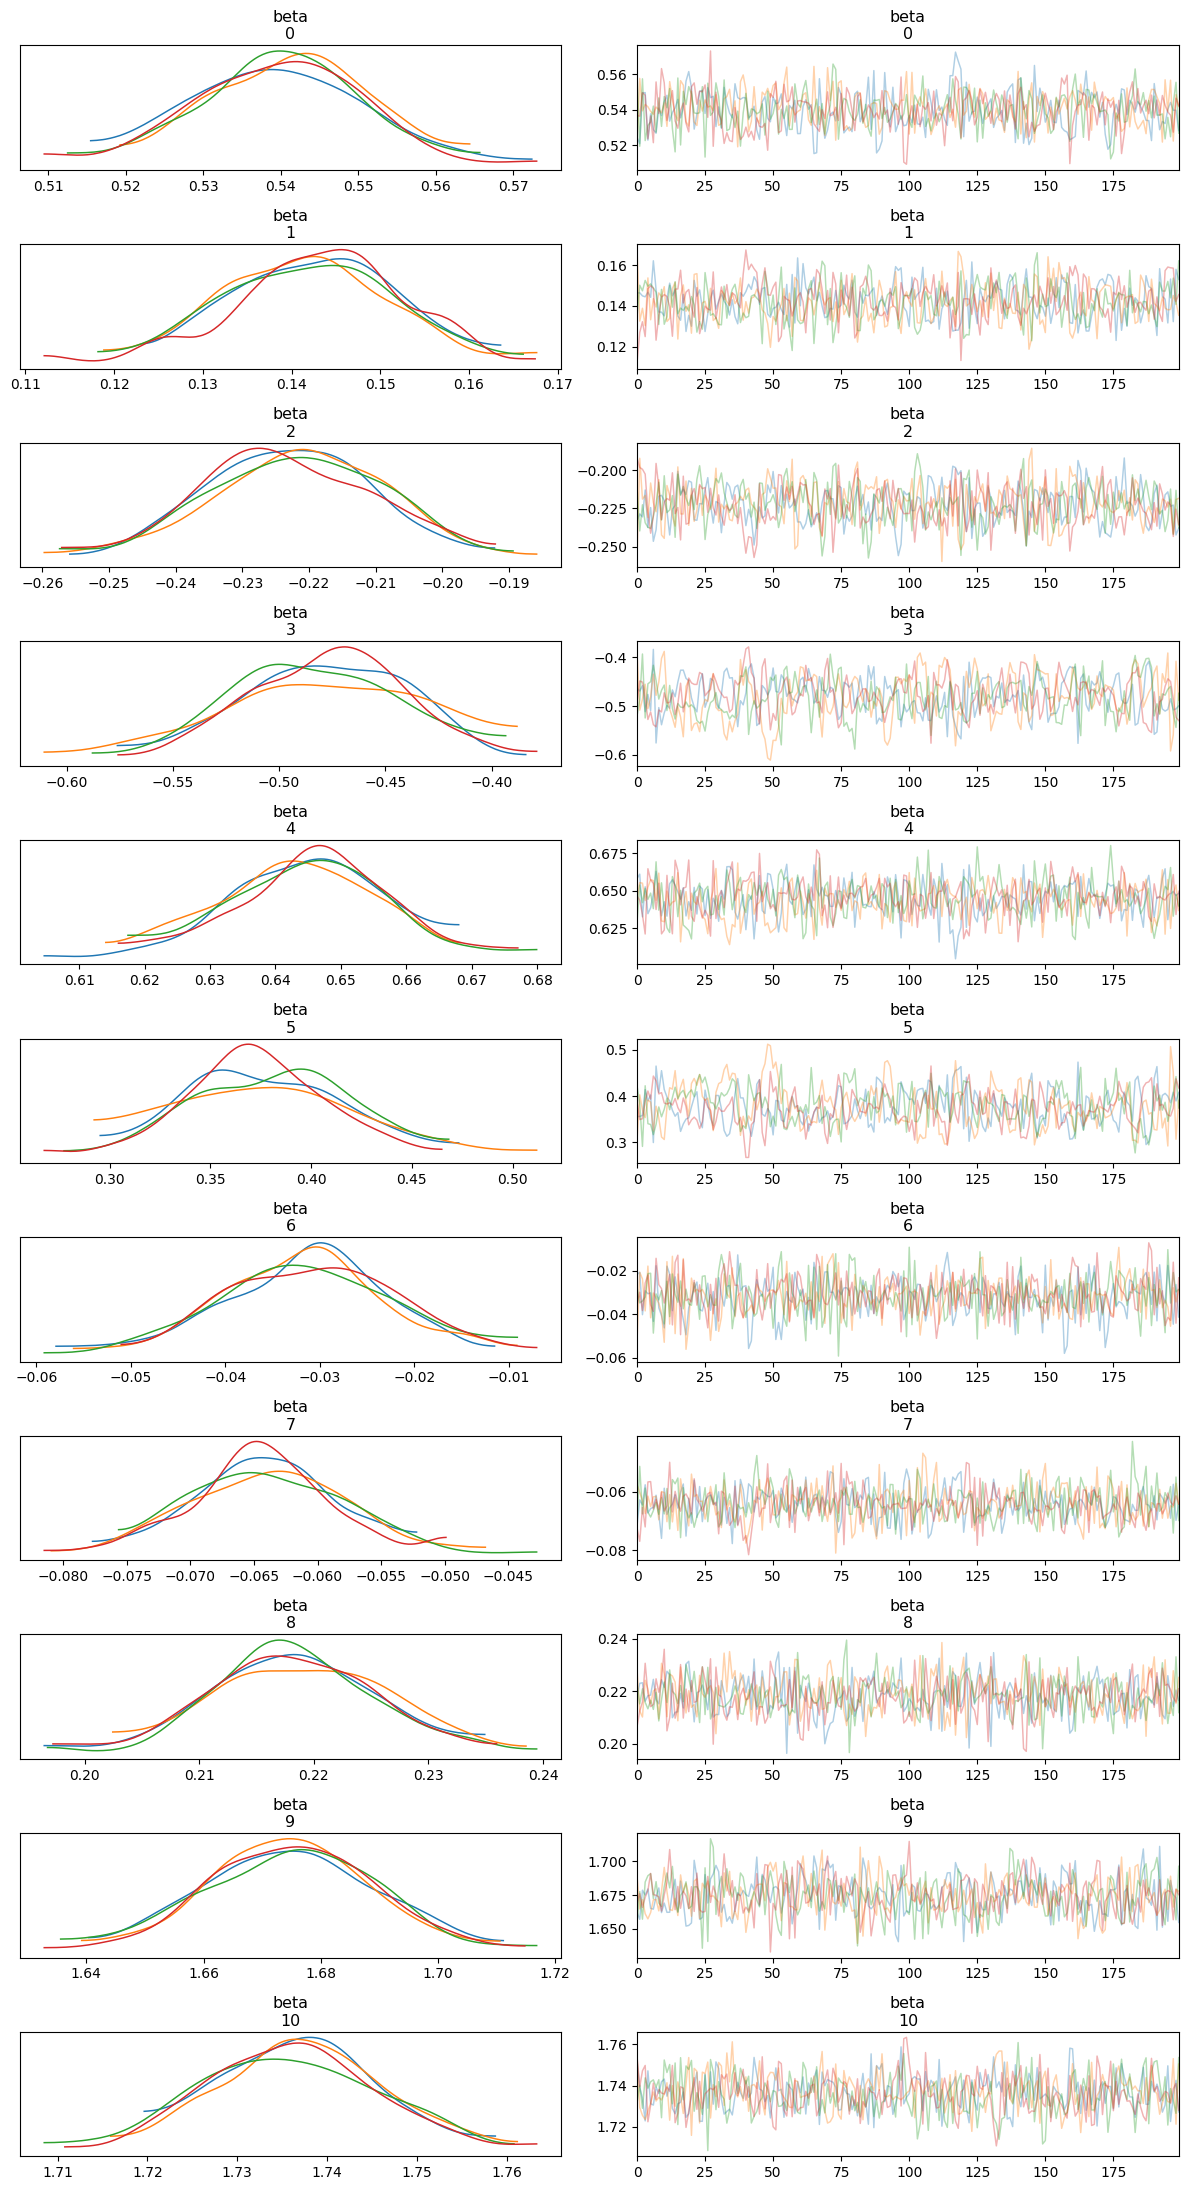

In [50]:
az.rcParams['plot.max_subplots'] = 50
az.plot_trace(posterior_az, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

In [51]:
posterior_az

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats

In [52]:
lam = posterior_az['posterior']['lambda']
lam

<xarray.DataArray 'lambda' (chain: 4, draw: 200, lambda_dim_0: 3840)>
array([[[ 2.30815 ,  3.92178 , 11.314   , ...,  3.03727 ,  0.617221,
          0.301296],
        [ 2.2788  ,  3.90015 , 11.1624  , ...,  2.96707 ,  0.604514,
          0.29528 ],
        [ 2.19492 ,  3.74242 , 11.0148  , ...,  3.06073 ,  0.614319,
          0.308327],
        ...,
        [ 2.22646 ,  3.72201 , 11.1947  , ...,  3.06755 ,  0.602084,
          0.300038],
        [ 2.20615 ,  3.86092 , 11.1366  , ...,  3.0552  ,  0.611004,
          0.303541],
        [ 2.22463 ,  3.83356 , 10.9468  , ...,  3.05791 ,  0.613395,
          0.302385]],

       [[ 2.32438 ,  3.88203 , 11.0447  , ...,  2.98176 ,  0.609504,
          0.310223],
        [ 2.14588 ,  3.94046 , 11.3452  , ...,  3.08361 ,  0.607921,
          0.282154],
        [ 2.1976  ,  3.79403 , 11.1277  , ...,  3.03878 ,  0.607073,
          0.296714],
...
        [ 2.17981 ,  3.80527 , 10.9424  , ...,  3.12306 ,  0.633206,
          0.312897],
        [ 2.12077 ,  3.8292  , 11.1115  , ...,  3.06677 ,  0.600146,
          0.285907],
        [ 2.28385 ,  4.04129 , 11.1371  , ...,  3.02267 ,  0.624854,
          0.306793]],

       [[ 2.31879 ,  3.86818 , 11.5758  , ...,  3.03638 ,  0.609632,
          0.30001 ],
        [ 2.28133 ,  3.92075 , 11.3018  , ...,  3.02384 ,  0.619447,
          0.300444],
        [ 2.24312 ,  3.91718 , 11.3248  , ...,  3.00755 ,  0.609926,
          0.299707],
        ...,
        [ 2.23579 ,  3.90869 , 11.1083  , ...,  3.05149 ,  0.616475,
          0.297613],
        [ 2.20351 ,  3.83257 , 11.1191  , ...,  3.11538 ,  0.618919,
          0.303332],
        [ 2.16908 ,  3.74879 , 11.0355  , ...,  3.09391 ,  0.612547,
          0.299937]]])
Coordinates:
  * chain         (chain) int32 0 1 2 3
  * draw          (draw) int32 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * lambda_dim_0  (lambda_dim_0) int32 0 1 2 3 4 5 ... 3835 3836 3837 3838 3839

In [53]:
lam.shape
lam.mean(axis=0).shape

(200, 3840)

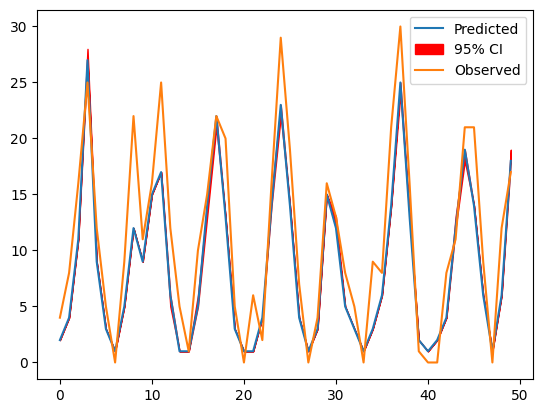

In [54]:
# Generating posterior predictive distribution confidence intervals
preds = np.round(lam.mean(axis=0).mean(axis=0))
lower = np.round(np.percentile(lam, 2.5, axis=0).mean(axis=0))
upper = np.round(np.percentile(lam, 97.5, axis=0).mean(axis=0))
x = np.arange(0, 50)
plt.plot(x, preds[x], label="Predicted")
plt.fill_between(x, lower[x], upper[x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()




In [55]:
#Identifting outliers
#We identify outliers by looking at the observations
#that have a large difference between the observed and
#predicted values

outliers = np.where(np.abs(preds - Y['Count_120']) > 10)[0]
print(outliers)
print(outliers.shape)


[ 132  238  346  384  391  410  422  429  478  519  599  605  647  648
  739  752  753  757  758  769  770  775  776  781  782  833  842  876
  877  913  926  931  943  957  958  963  964  969  976  977  978  984
  985  990  991  992  997  998  999 1065 1066 1073 1078 1079 1080 1101
 1136 1142 1171 1222 1260 1324 1332 1526 1583 1710 1718 1724 1725 1731
 1744 1745 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784
 1791 1792 1857 1859 1871 1878 1879 1889 1983 2020 2033 2041 2047 2055
 2073 2090 2105 2137 2140 2175 2227 2234 2259 2305 2306 2359 2399 2462
 2464 2574 2580 2622 2648 2659 2662 2663 2668 2673 2684 2685 2687 2695
 2707 2708 2709 2713 2714 2715 2718 2719 2721 2722 2723 2730 2733 2736
 2737 2742 2748 2749 2755 2773 2780 2812 2818 2824 2825 2826 2840 2846
 2847 2851 2857 2858 2859 2864 2865 2866 2867 2871 2872 2873 2878 2879
 2880 2881 2885 2886 2887 2892 2893 2894 2895 2899 2900 2904 2905 2906
 2907 2918 3014 3042 3095 3147 3161 3356 3423 3443 3495 3503 3508 3509
 3510 

In [56]:
# We identify the outliers using the 95% confidence interval

outliers = np.where((lower > Y['Count_120']) | (upper < Y['Count_120']))[0]
outliers.shape

(3395,)

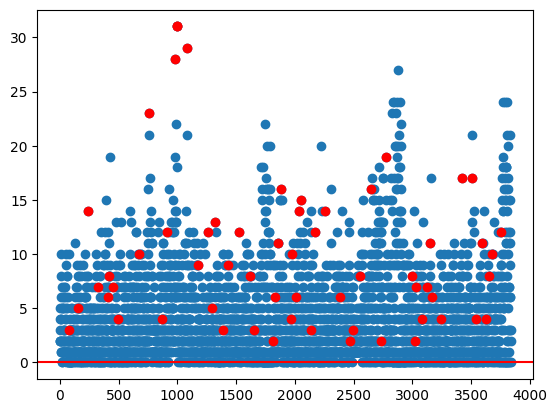

[ 132  238  346  384  391  410  422  429  478  519  599  605  647  648
  739  752  753  757  758  769  770  775  776  781  782  833  842  876
  877  913  926  931  943  957  958  963  964  969  976  977  978  984
  985  990  991  992  997  998  999 1065 1066 1073 1078 1079 1080 1101
 1136 1142 1171 1222 1260 1324 1332 1526 1583 1710 1718 1724 1725 1731
 1744 1745 1750 1756 1757 1758 1763 1769 1770 1774 1777 1778 1783 1784
 1791 1792 1857 1859 1871 1878 1879 1889 1983 2020 2033 2041 2047 2055
 2073 2090 2105 2137 2140 2175 2227 2234 2259 2305 2306 2359 2399 2462
 2464 2574 2580 2622 2648 2659 2662 2663 2668 2673 2684 2685 2687 2695
 2707 2708 2709 2713 2714 2715 2718 2719 2721 2722 2723 2730 2733 2736
 2737 2742 2748 2749 2755 2773 2780 2812 2818 2824 2825 2826 2840 2846
 2847 2851 2857 2858 2859 2864 2865 2866 2867 2871 2872 2873 2878 2879
 2880 2881 2885 2886 2887 2892 2893 2894 2895 2899 2900 2904 2905 2906
 2907 2918 3014 3042 3095 3147 3161 3356 3423 3443 3495 3503 3508 3509
 3510 

In [57]:
#identifying outliers through residuals
#We identify outliers by looking at the observations
#that have a large difference between the observed and
#predicted values

idx_over_30 = np.where(preds > 30)[0]

residuals = np.abs(Y['Count_120'] - preds)

#plot these residuals

plt.scatter(np.arange(0, len(residuals)),residuals)
plt.scatter(idx_over_30, residuals[idx_over_30], color='r')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

outliers = np.where(residuals > 10)[0]
print(outliers)
print(outliers.shape)

total_outliers = np.unique(np.concatenate((outliers, idx_over_30)))
print(total_outliers)
print(total_outliers.shape)

In [58]:
# plot a map of the residuals where you can easily identify ste stations with high residuals

mask = residuals > 10
mask = mask.astype(int)

# group by station
mask = mask.groupby(stations).sum()
mask = mask.reset_index()
mask.columns = ['Station', 'Count']
mask = mask.sort_values(by='Count', ascending=False)
mask = mask.reset_index(drop=True)
print(mask)

mask_2 = residuals > 10
mask_2 = mask_2.astype(int)

# group by year
mask_2 = mask_2.groupby(years).sum()
mask_2 = mask_2.reset_index()
mask_2.columns = ['Year', 'Count']
mask_2 = mask_2.sort_values(by='Count', ascending=False)
mask_2 = mask_2.reset_index(drop=True)
print(mask_2)


    Station  Count
0     10025     34
1     12020     33
2      9991     24
3      6804     21
4      5739     19
5      9997      8
6      5735      7
7     10437      6
8      5742      6
9      6884      6
10     5732      5
11     6904      5
12     9861      5
13     6818      5
14     5738      4
15     5730      4
16     9972      4
17     5719      4
18    10584      4
19     5749      4
20     9899      3
21    10454      3
22    10171      3
23     5721      3
24    10463      2
25    10081      2
26    10288      2
27     5750      2
28     5952      2
29    10041      1
30     6832      1
31     9882      1
32     9856      1
33     5710      1
34     6665      1
35     6582      1
36     5725      1
37     5717      1
38     9925      0
39     6691      0
40    10270      0
41    10282      0
42     5960      0
43     5718      0
44     5707      0
    Year  Count
0     13     40
1      3     24
2      2     22
3     10     22
4     11     22
5     12     22
6      9     2

In [59]:
stations_to_rm = mask[mask['Count'] > 10]['Station'].values
print(stations_to_rm)

[10025 12020  9991  6804  5739]


In [60]:
mae = np.mean(residuals)
print(mae)
mse = np.mean(residuals**2)
print(mse)

3.7934895833333333
29.559635416666666


In [61]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_out = {
    "N": len(Y) - len(total_outliers),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45,
    "station": transformed_stations.drop(index=total_outliers),
    "year": years.drop(index=total_outliers),
    "y": Y['Count_120'].drop(index=total_outliers),
    "X": X_std.drop(index=total_outliers)
}


fit_2 = model_base.sample(data=data_no_out, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az_2 = az.from_cmdstanpy(fit_2) 

03:16:16 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▍        | 00:00 Status




chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)


chain 1 |████▎     | 00:04 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:06 Iteration: 200 / 500 [ 40%]  (Warmup)


chain 1 |████████▌ | 00:11 Iteration: 301 / 500 [ 60%]  (Sampling)


chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


03:16:32 - cmdstanpy - INFO - CmdStan done processing.


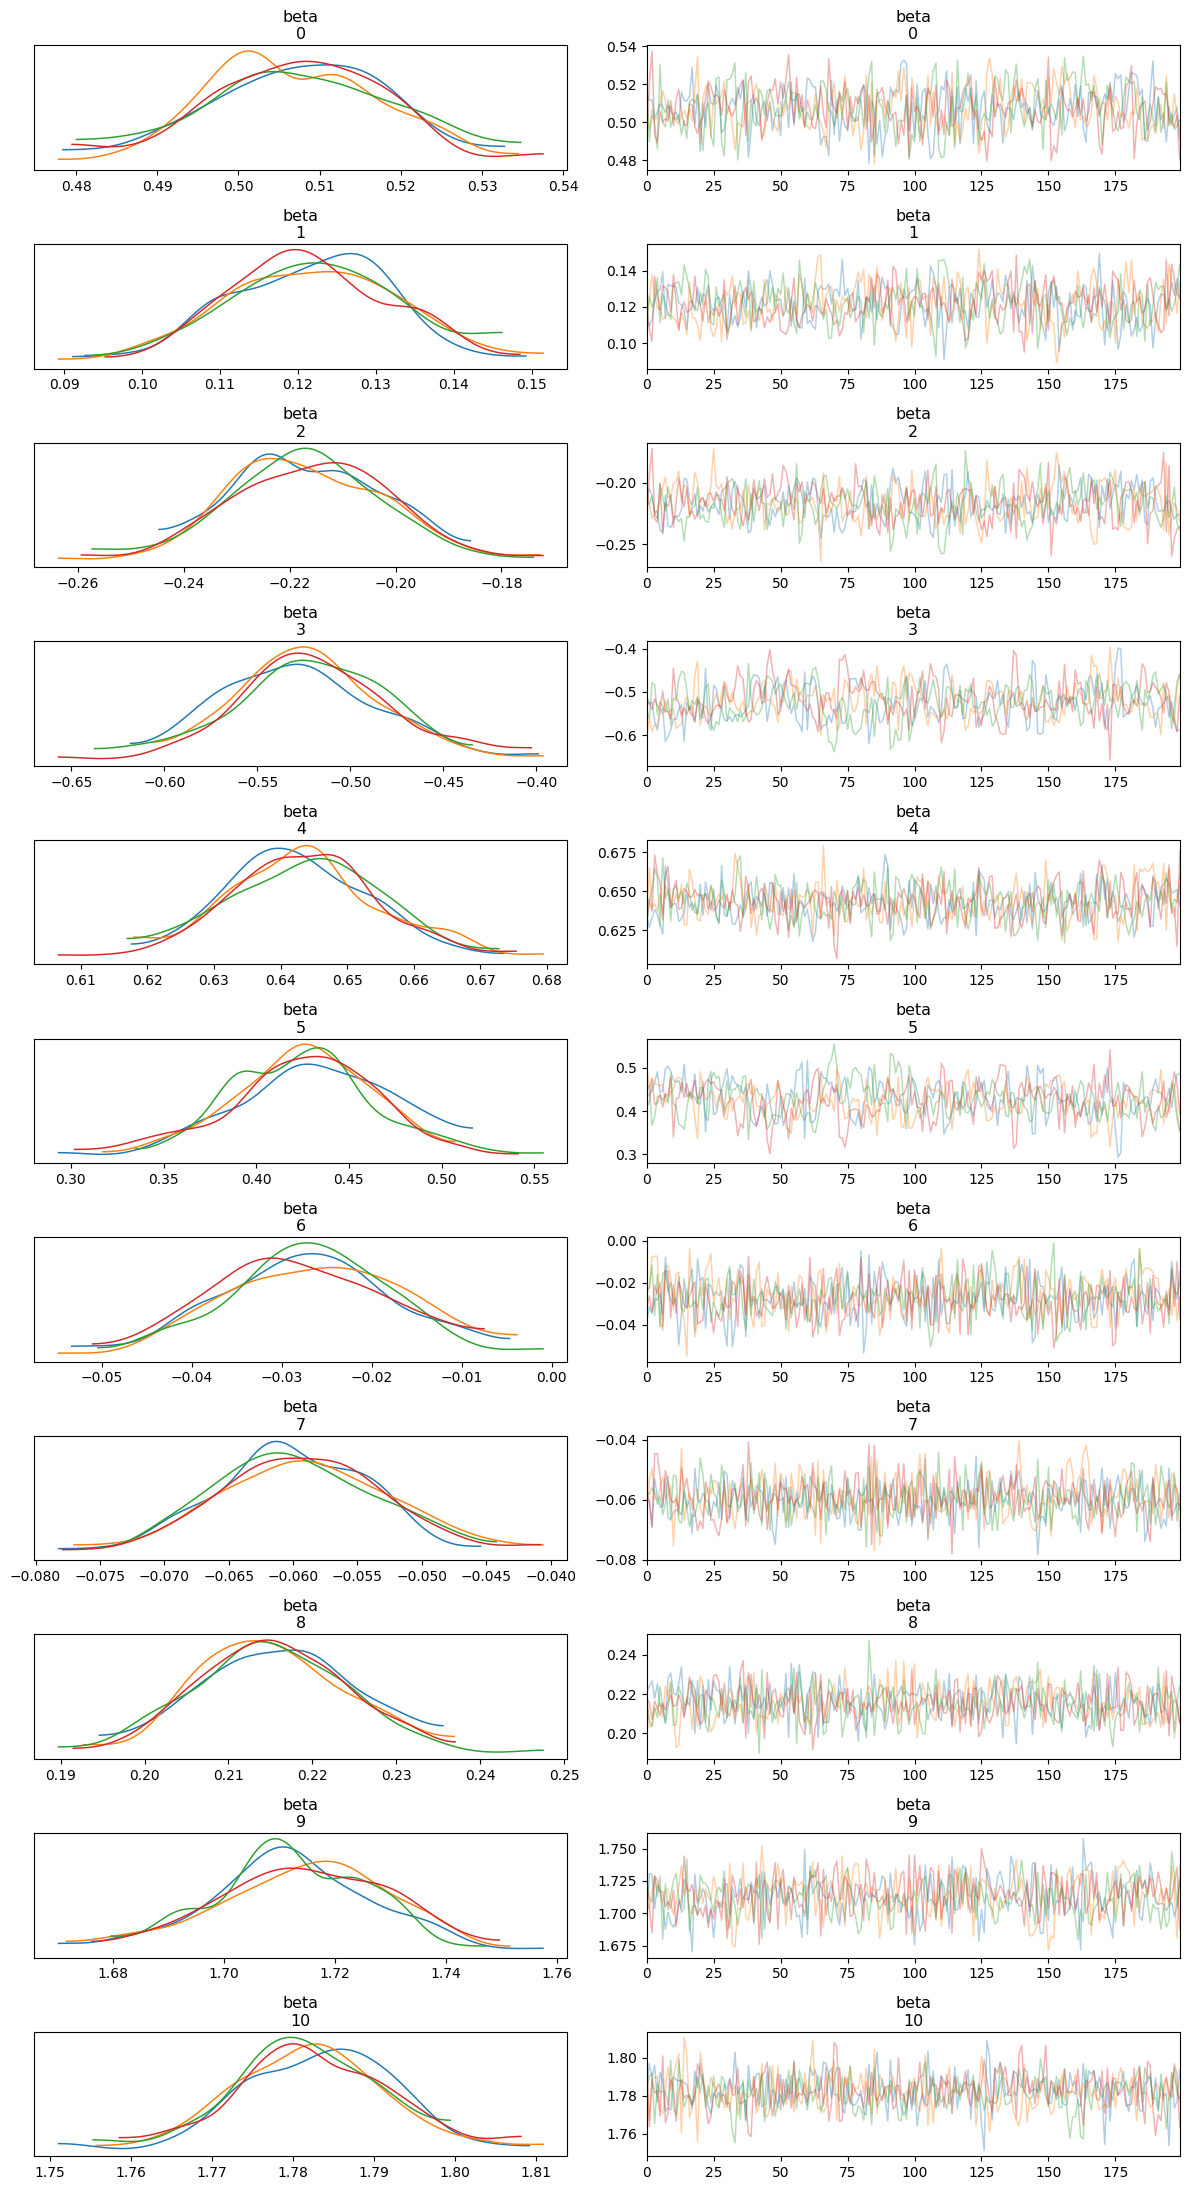

In [62]:
az.plot_trace(posterior_az_2, var_names = ['beta'], compact=False)
plt.tight_layout()
plt.show()

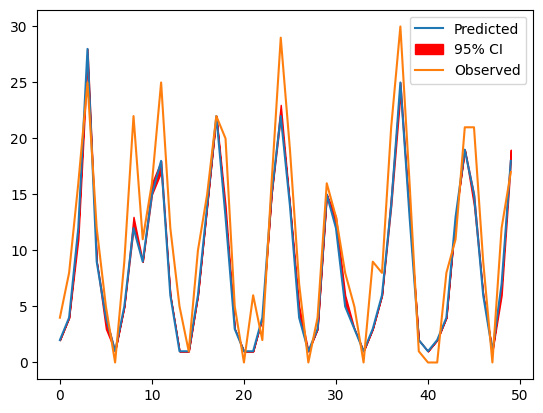

In [63]:
lam_2 = posterior_az_2['posterior']['lambda']

pred_2 = np.round(lam_2.mean(axis=0).mean(axis=0))
lower_2 = np.round(np.percentile(lam_2, 2.5, axis=0).mean(axis=0))
upper_2 = np.round(np.percentile(lam_2, 97.5, axis=0).mean(axis=0))

Y_no_out = Y.drop(index=total_outliers)
Y_no_out = Y_no_out.reset_index(drop=True)
x = np.arange(0, 50)
plt.plot(x, pred_2[x], label="Predicted")
plt.fill_between(x, lower_2[x], upper_2[x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y_no_out.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()


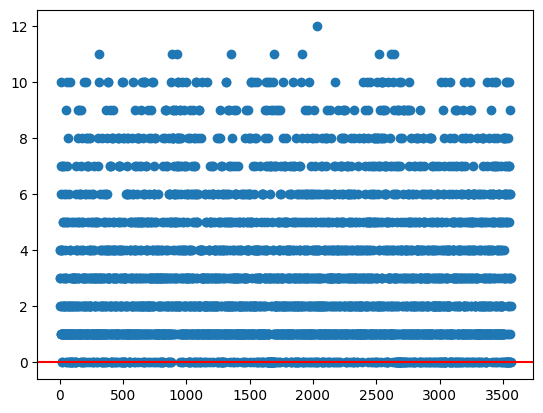

In [64]:
residuals_2 = np.abs(Y_no_out['Count_120'] - pred_2)

#plot these residuals

plt.scatter(np.arange(0, len(residuals_2)),residuals_2)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [65]:
mae_2 = np.mean(residuals_2)
print(mae_2)
mse_2 = np.mean(residuals_2**2)
print(mse_2)

3.043490460157127
15.627665544332212


In [66]:
transformed_stations = pd.Series(transformed_stations)
years = pd.Series(years)

data_no_stat = {
    "N": len(Y.loc[~Y['idSensore'].isin(stations_to_rm),:]),
    "P": X_std.shape[1],
    "nyears": 13,
    "nstations": 45 - len(stations_to_rm),
    "station": transformed_stations.loc[~Y['idSensore'].isin(stations_to_rm)],
    "year": years.loc[~Y['idSensore'].isin(stations_to_rm)],
    "y": Y.loc[~Y['idSensore'].isin(stations_to_rm),'Count_120'],
    "X": X_std.loc[~Y['idSensore'].isin(stations_to_rm),:]
}


fit_3 = model_base.sample(data=data_no_stat, chains=4, parallel_chains=4, 
    iter_warmup=300, iter_sampling=200)
posterior_az_3 = az.from_cmdstanpy(fit_3) 

03:16:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▍        | 00:00 Status

chain 1 |██▊       | 00:01 Iteration:   1 / 500 [  0%]  (Warmup)





chain 1 |████▎     | 00:03 Iteration: 100 / 500 [ 20%]  (Warmup)


chain 1 |█████▋    | 00:06 Iteration: 200 / 500 [ 40%]  (Warmup)

chain 1 |████████▌ | 00:10 Iteration: 301 / 500 [ 60%]  (Sampling)



chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     


03:17:02 - cmdstanpy - INFO - CmdStan done processing.


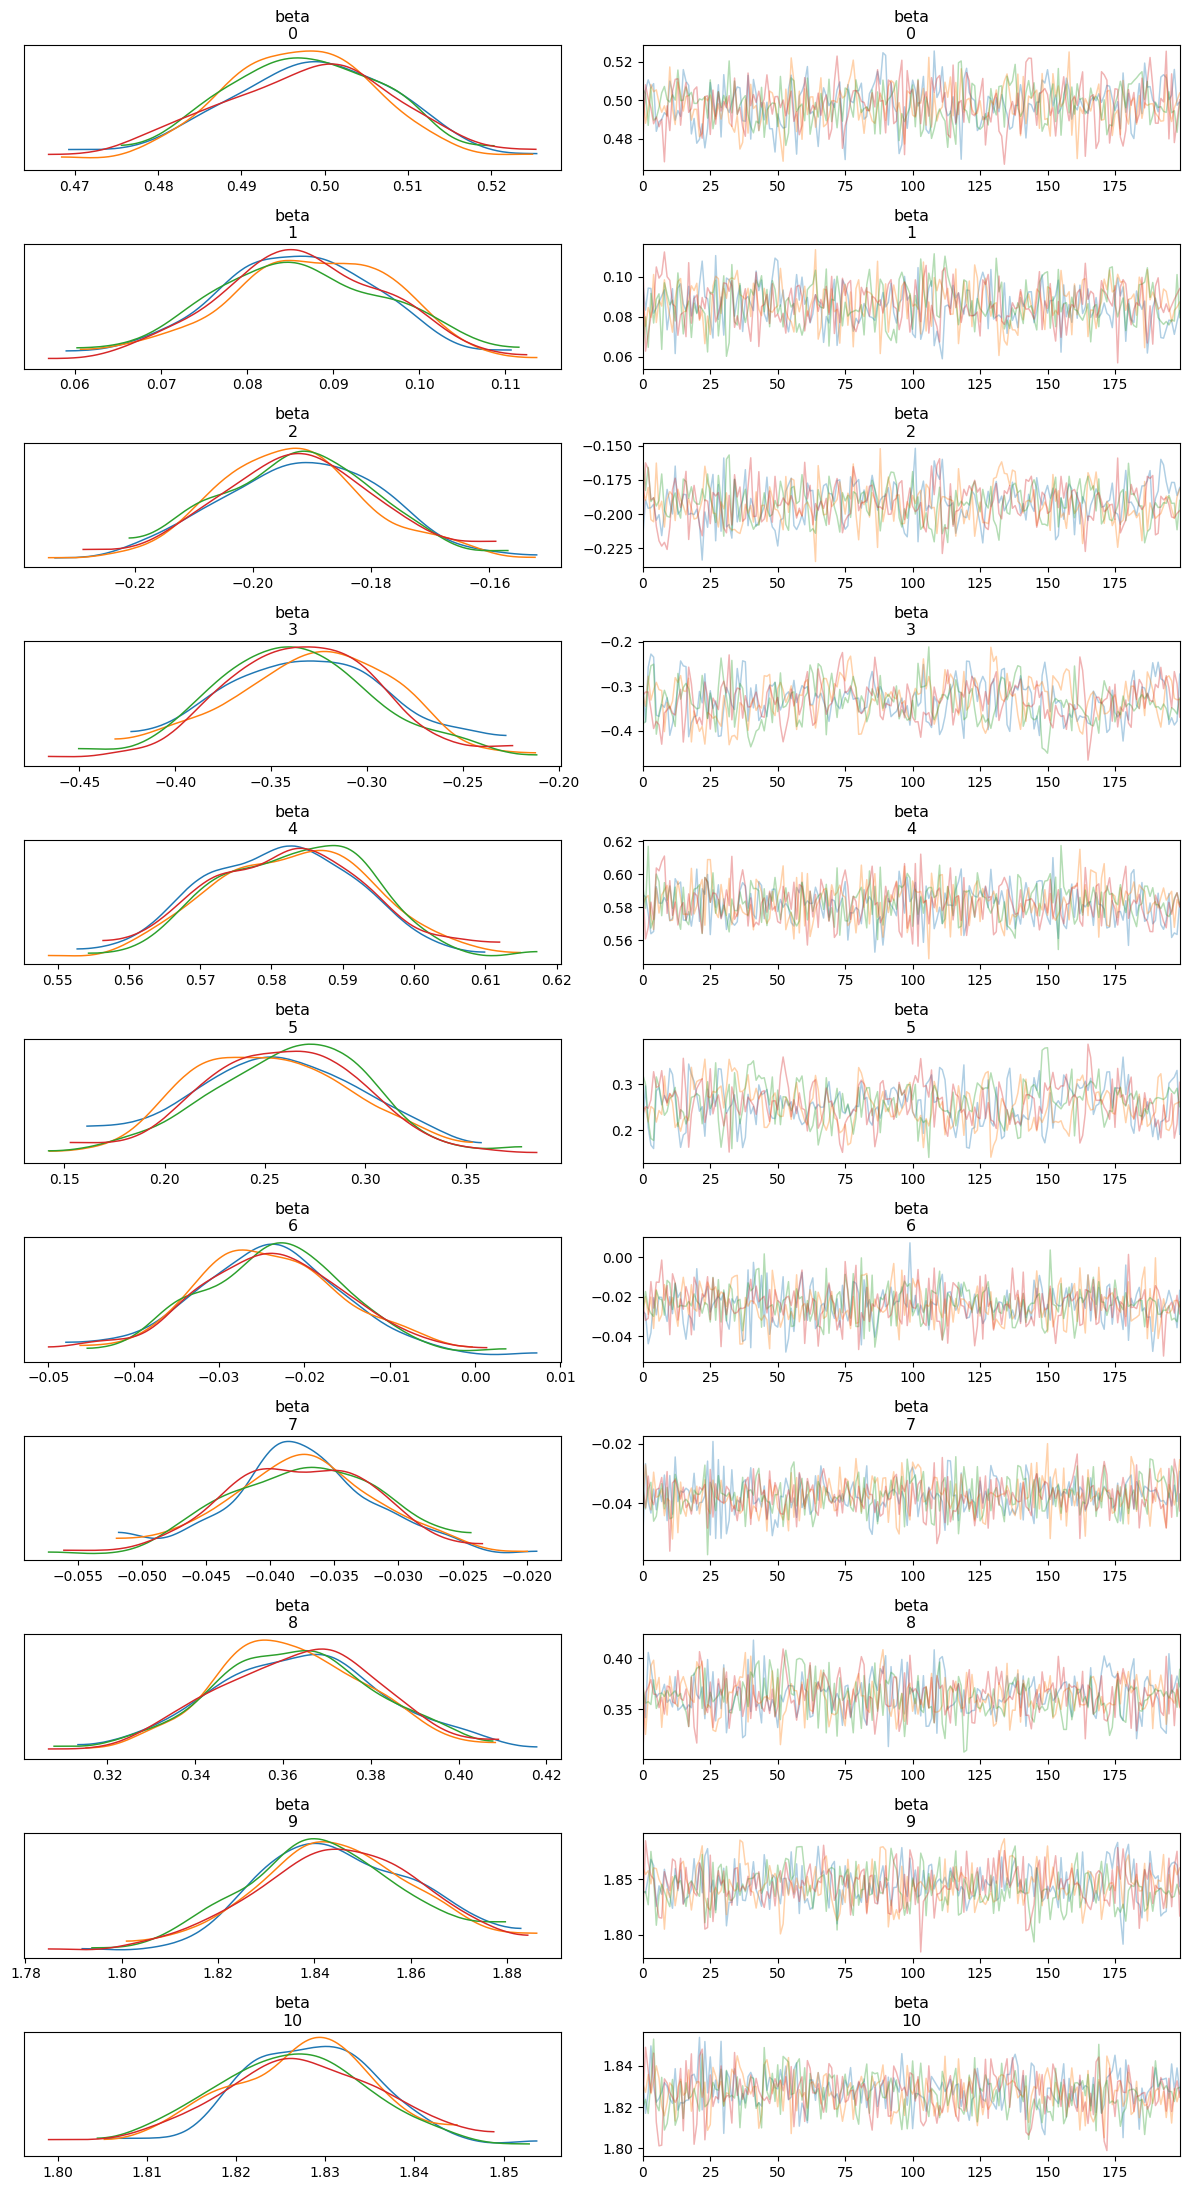

In [67]:
az.plot_trace(posterior_az_3, var_names = ['beta'],  compact=False)
plt.tight_layout()
plt.show()

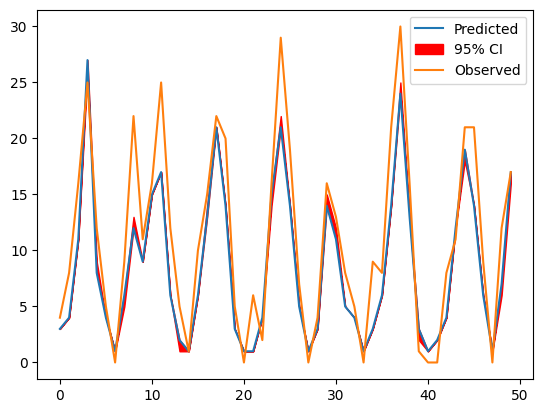

In [68]:
lam_3 = posterior_az_3['posterior']['lambda']

pred_3 = np.round(lam_3.mean(axis=0).mean(axis=0))
lower_3 = np.round(np.percentile(lam_3, 2.5, axis=0).mean(axis=0))
upper_3 = np.round(np.percentile(lam_3, 97.5, axis=0).mean(axis=0))

Y_no_stat = Y.loc[~Y['idSensore'].isin(stations_to_rm),:]
Y_no_stat = Y_no_stat.reset_index(drop=True)
x = np.arange(0, 50)
plt.plot(x, pred_3[x], label="Predicted")
plt.fill_between(x, lower_3[x], upper_3[x], alpha=1, label="95% CI", color='red')
plt.plot(x, Y_no_stat.loc[x, 'Count_120'], label="Observed")
plt.legend()
plt.show()

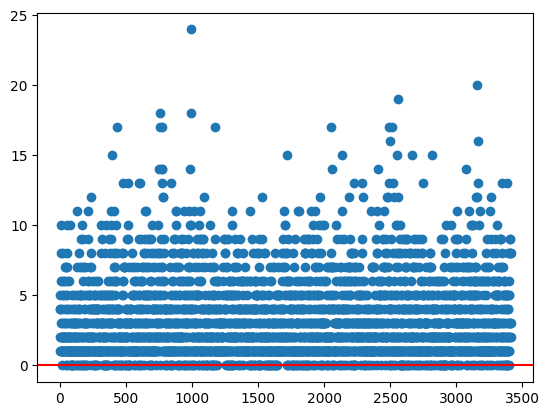

In [69]:
residuals_3 = np.abs(Y_no_stat['Count_120'] - pred_3)

#plot these residuals
plt.scatter(np.arange(0, len(residuals_3)),residuals_3)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [70]:
mae_3 = np.mean(residuals_3)
print(mae_3)
mse_3 = np.mean(residuals_3**2)
print(mse_3)

3.2338118956929387
18.56929387635511


In [71]:
print("WAIC_1: ", az.waic(posterior_az, var_name='log_lik'))
print("WAIC_2: ", az.waic(posterior_az_2, var_name='log_lik'))
print("WAIC_3: ", az.waic(posterior_az_3, var_name='log_lik'))
print("LOO_1: ", az.loo(posterior_az, var_name='log_lik'))
print("LOO_2: ", az.loo(posterior_az_2, var_name='log_lik'))
print("LOO_3: ", az.loo(posterior_az_3, var_name='log_lik'))

c:\Users\matte\anaconda3\envs\stan\lib\site-packages\arviz\stats\stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC_1:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13615.05   237.15
p_waic       41.31        -

There has been a warning during the calculation. Please check the results.
WAIC_2:  Computed from 800 posterior samples and 3564 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -10143.94   112.71
p_waic       23.87        -
WAIC_3:  Computed from 800 posterior samples and 3413 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -9659.78    93.47
p_waic       23.11        -
LOO_1:  Computed from 800 posterior samples and 3840 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -13615.30   237.16
p_loo       41.56        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     3840  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [72]:
eta = posterior_az['posterior']['eta']
eta
len(np.unique(stations))

KeyError: 'eta'

In [73]:
inference = []
for i in range(len(np.unique(stations))):
    ar1 = eta[0, :, i]
    ar2 = eta[1, :, i]
    ar3 = eta[2, :, i]
    ar4 = eta[3, :, i]
    current_iteration_df = np.concatenate((ar1, ar2, ar3, ar4), axis=0)
    inference.append(current_iteration_df)

len(current_iteration_df)
len(inference)

NameError: name 'eta' is not defined

In [ ]:
df = pd.DataFrame(inference).transpose()
df.shape
df.columns = np.unique(stations)
df.columns.values

array([ 5707,  5710,  5717,  5718,  5719,  5721,  5725,  5730,  5732,
        5735,  5738,  5739,  5742,  5749,  5750,  5952,  5960,  6582,
        6665,  6691,  6804,  6818,  6832,  6884,  6904,  9856,  9861,
        9882,  9899,  9925,  9972,  9991,  9997, 10025, 10041, 10081,
       10171, 10270, 10282, 10288, 10437, 10454, 10463, 10584, 12020],
      dtype=int64)

In [ ]:
csv_path = '../Datasets/eta_120.csv'
data = pd.DataFrame(df)
# Save the DataFrame to a CSV file
data.to_csv(csv_path, index=False)